# Session 4

This task is all about CNNs (Convolutional Neural Networks) 

It's recommend to read [the relevant chapter in the textbook](https://d2l.ai/chapter_convolutional-neural-networks/index.html) in case you have trouble remembering certain concepts about how CNNs work.

[This lecture](https://www.youtube.com/watch?v=bNb2fEVKeEo) is also great in case you prefer video. 

We will be using the GTSRB (German Traffic Sign Recognition Benchmark) dataset.

The goal is to predict which traffic sign an image represents from 43 classes.



## As always, we start by importing the packages we need.

Note: You'll notice here a new package called torchvision:
> The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision

In [1]:
import os
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt

## First, we'll download the dataset. The dataset we'll be using is actually directly available to download using torchvision

Torchvision contains a lot of public datasets that can be installed directly using the package. If you need datasets from other sources though, you'll need to download them yourself.

In [2]:
#For more information see https://pytorch.org/vision/stable/datasets.html
dataset = torchvision.datasets.GTSRB(root = ".", download = True) # "." means current directory

100%|██████████| 187490228/187490228 [00:07<00:00, 23949647.58it/s]


Extracting gtsrb/GTSRB-Training_fixed.zip to gtsrb


## Now that we've downloaded the dataset, let's inspect it. 

Do not that, unlike tabular datasets that can usually be represented in a single csv that you can read using pandas. Image datasets can have different formats and be organized in different ways. So a good idea is to check how the dataset is organized after downloading it and possibly reorganizing it.

Note: we'll use shell commands to print folder contents and perform similar file system operations. We can do the same using python code but using shell commands can often be easier and more concise.

In [3]:
#Prints current working directory, can also instead use os.getcwd()
!pwd

/content


In [4]:
#List contents of argument folder, can also instead type os.listdir(directory_path)

!ls . # "." means current directory

gtsrb  sample_data


## After listing a few directories, we arrive at the directory with the training data. We find some numbered folders and a readme file. Let's see what it has to say! 

In [5]:
!ls gtsrb/GTSRB/Training

00000  00005  00010  00015  00020  00025  00030  00035	00040
00001  00006  00011  00016  00021  00026  00031  00036	00041
00002  00007  00012  00017  00022  00027  00032  00037	00042
00003  00008  00013  00018  00023  00028  00033  00038	Readme.txt
00004  00009  00014  00019  00024  00029  00034  00039


In [6]:
!cat gtsrb/GTSRB/Training/Readme.txt

**********************************************
The German Traffic Sign Recognition Benchmark
**********************************************

This archive contains the training set of the 
"German Traffic Sign Recognition Benchmark".

This training set is supposed be used for the online competition 
as part of the IJCNN 2011 competition. It is a subset of the final
training set that will be published after the online competition is
closed. 


**********************************************
Archive content
**********************************************
This archive contains the following structure:

There is one directory for each of the 43 classes (0000 - 00043).
Each directory contains the corresponding training images and one 
text file with annotations, eg. GT-00000.csv. 


**********************************************
Image format and naming
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The

## Alright, seems like every folder in the previous directory is for a single class. There's also a csv file in every class directory that has additional labels but in this task we're only interested in classifying images into different classes so the folder name is enough as a label. 

## Now that we know the directory where our data is placed and how it's organized. We can save the directory path to a variable to avoid typing it over and over. 

In [7]:
training_dir = "/content/gtsrb/GTSRB/Training/"

Tip: we can also use python variables in shell commands when using notebooks! We need to wrap them in braces {}.

In [8]:
!ls {training_dir}

00000  00005  00010  00015  00020  00025  00030  00035	00040
00001  00006  00011  00016  00021  00026  00031  00036	00041
00002  00007  00012  00017  00022  00027  00032  00037	00042
00003  00008  00013  00018  00023  00028  00033  00038	Readme.txt
00004  00009  00014  00019  00024  00029  00034  00039


In [9]:
!ls {training_dir}/00000

00000_00000.ppm  00001_00008.ppm  00002_00016.ppm  00003_00024.ppm
00000_00001.ppm  00001_00009.ppm  00002_00017.ppm  00003_00025.ppm
00000_00002.ppm  00001_00010.ppm  00002_00018.ppm  00003_00026.ppm
00000_00003.ppm  00001_00011.ppm  00002_00019.ppm  00003_00027.ppm
00000_00004.ppm  00001_00012.ppm  00002_00020.ppm  00003_00028.ppm
00000_00005.ppm  00001_00013.ppm  00002_00021.ppm  00003_00029.ppm
00000_00006.ppm  00001_00014.ppm  00002_00022.ppm  00004_00000.ppm
00000_00007.ppm  00001_00015.ppm  00002_00023.ppm  00004_00001.ppm
00000_00008.ppm  00001_00016.ppm  00002_00024.ppm  00004_00002.ppm
00000_00009.ppm  00001_00017.ppm  00002_00025.ppm  00004_00003.ppm
00000_00010.ppm  00001_00018.ppm  00002_00026.ppm  00004_00004.ppm
00000_00011.ppm  00001_00019.ppm  00002_00027.ppm  00004_00005.ppm
00000_00012.ppm  00001_00020.ppm  00002_00028.ppm  00004_00006.ppm
00000_00013.ppm  00001_00021.ppm  00002_00029.ppm  00004_00007.ppm
00000_00014.ppm  00001_00022.ppm  00003_00000.ppm  00004_00008

## Now it's a good idea to inspect some images to see their size and verify they're correct.

Here are the class names we're predicting in order.

In [10]:
classes = ['Speed limit (20km/h)', 
 'Speed limit (30km/h)', 
 'Speed limit (50km/h)', 
 'Speed limit (60km/h)', 
 'Speed limit (70km/h)', 
 'Speed limit (80km/h)', 
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)', 
 'Speed limit (120km/h)',
 'No passing',
 'No passing veh over 3.5 tons',
 'Right-of-way at intersection',
 'Priority road', 
 'Yield',
 'Stop',
 'No vehicles',
 'Veh > 3.5 tons prohibited',
 'No entry',
 'General caution',
 'Dangerous curve left',
 'Dangerous curve right',
 'Double curve',
 'Bumpy road',
 'Slippery road',
 'Road narrows on the right',
 'Road work',
 'Traffic signals',
 'Pedestrians', 
 'Children crossing',
 'Bicycles crossing',
 'Beware of ice/snow',
 'Wild animals crossing', 
 'End speed + passing limits',
 'Turn right ahead',
 'Turn left ahead',
 'Ahead only',
 'Go straight or right',
 'Go straight or left',
 'Keep right',
 'Keep left',
 'Roundabout mandatory',
 'End of no passing',
 'End no passing veh > 3.5 tons']

num_classes = len(classes)

## We'll use OpenCV to load images. OpenCV is the most popular python library for manipulating images (along with Pillow, but Pillow is written in Python while OpenCV is written in C and C++ so it's faster)

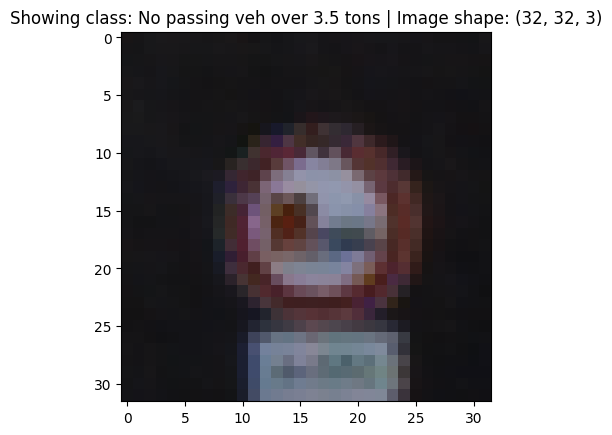

In [11]:
#Importing OpenCV
import cv2 
#For selecting random directories and images
import random 

#Choose a random class from the training directory
random_class = random.choice(os.listdir(training_dir))
#Choose a random image within the class 
random_image = random.choice(os.listdir(f"{training_dir}/{random_class}"))


img = cv2.imread(f"{training_dir}/{random_class}/{random_image}")
#OpenCV uses BGR instead of RGB so we need to convert it
# https://stackoverflow.com/a/33787594
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.title(f"Showing class: {classes[int(random_class[3:])]} | Image shape: {img.shape}")
plt.imshow(img)

## Now we're ready to start preparing the dataset and the model for training. We'll start by preparing the dataset.

> Transforms are common image transformations available in the torchvision.transforms module. They can be chained together using Compose.

In [12]:
from torchvision import transforms

batch_size = 4

#For more information see: https://pytorch.org/vision/main/transforms.html
transform = transforms.Compose([
    # You can add other transformations in this list
    transforms.Resize((40,40)),
    transforms.ToTensor()
])

#Use ImageFolder to load the dataset
dataset = torchvision.datasets.ImageFolder(training_dir, transform=transform)
#Split the dataset into training and validation sets
train_ds, val_ds = torch.utils.data.random_split(dataset, [0.8, 0.2])


#Define dataloaders to load the images in batches of size batch_size
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True,
                                         drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size, shuffle=True,
                                         drop_last=True)

## We can have a closer look at the dataloader to see how it differs from the dataset

In [13]:
for X,y in train_dataloader:
  # X has shape (batch_size, n_channels, height, width)
  # y has shape (batch_size,)
  # Each iteration provides a single batch till the dataset ends
  print(X.shape, y)
  break

torch.Size([4, 3, 40, 40]) tensor([35, 14, 12, 18])


## We can also inspect class frequencies from the dataset to see if some classes are underrepresented

<BarContainer object of 43 artists>

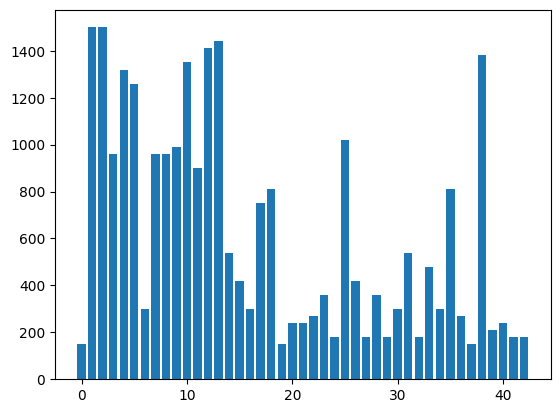

In [14]:
from collections import Counter

classes_freqs = Counter(dataset.targets)

plt.bar(classes_freqs.keys(), classes_freqs.values())

## Now let's define the network 

We'll be using a simple network with an architecture similar to [LeNet](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html)

In [15]:
num_classes = 43

net = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2), 
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            #TODO: Add a nn.Conv2d layer with 6 input channels, 
            #      16 output channels, and a kernel_size=5
            nn.Conv2d(6, 16, kernel_size=5),
            #TODO: Add a nn.ReLU activation
            nn.ReLU(),
            #TODO: Add a nn.MaxPool2d layer with kernel_size=2 and stride=2 
            nn.MaxPool2d(kernel_size=2, stride=2),
            #TODO: Add a nn.Flatten() before using Linear layers
            nn.Flatten(),
            #TODO: Add a nn.Linear with input 1024 and output 512
            nn.Linear(1024, 512),
            #TODO: Add a nn.ReLU activation
            nn.ReLU(),
            #TODO: Add a nn.Linear with input 512 and output 256
            nn.Linear(512, 256),
            #TODO: Add a nn.ReLU activation
            nn.ReLU(),
            #TODO: Add a nn.Linear with input 256 and output=num_classes
            nn.Linear(256, num_classes)
            )


def init_weights(layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        #TOOD: call torch.nn.init.xavier_uniform_ on layer.weight
        nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.01)

#Initialize weights using Xavier transform
net.apply(init_weights)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=43, bias=True)
)

In [17]:
epochs = 8


#TODO: Select torch.optim.Adam and use net.parameters() as an argument 
#      For more information see: 
#      https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optim = torch.optim.Adam(net.parameters())
#TODO: Select nn.CrossEntropyLoss() as a loss function
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(epochs):
    #TODO: Call net.train() to start training mode
    net.train()
    train_correct = 0
    train_loss = 0
    for X, y in train_dataloader:
        #TODO: Call optim.zero_grad to zero out the gradient
        optim.zero_grad()
        #TODO: call net on the input X to generate predictions
        pred =net(X) 
        #TODO: Calculate loss using loss_fn on pred and y 
        loss = loss_fn(pred, y)
        #See: https://stackoverflow.com/a/61094330 
        train_loss += loss.item() * X.size(0)
        pred = torch.argmax(pred, dim=-1)
        train_correct += (pred == y).float().sum()
        #TODO: Call loss.backward and optim.step
        loss.backward()
        optim.step()

    #TODO: Put the network into eval mode
    net.eval()
    val_correct = 0
    val_loss = 0

    for X, y in val_dataloader:
      #TODO: Generate predictions and calculate loss
      pred = net(X)
      loss = loss_fn(pred, y)
      
      val_loss += loss.item() * X.size(0)
      pred = torch.argmax(pred, dim=-1)
      val_correct += (pred == y).float().sum()



    train_loss /= len(train_ds)
    train_losses.append(train_loss)

    val_loss /= len(val_ds)
    val_losses.append(val_loss)

    train_accuracy = 100 * train_correct / len(train_ds)
    val_accuracy = 100 * val_correct / len(val_ds)

    print(f"Epoch: {epoch} Train loss: {train_loss} Train accuracy: {train_accuracy} \
                           Val loss: {val_loss} Val accuracy: {val_accuracy}")


Epoch: 0 Train loss: 0.3184134896959084 Train accuracy: 90.3575439453125                            Val loss: 0.15243680435679788 Val accuracy: 94.85736083984375
Epoch: 1 Train loss: 0.14445245750324356 Train accuracy: 95.89433288574219                            Val loss: 0.25904644656619363 Val accuracy: 94.969970703125
Epoch: 2 Train loss: 0.09887927372094615 Train accuracy: 97.13776397705078                            Val loss: 0.06356630078754756 Val accuracy: 98.3108139038086
Epoch: 3 Train loss: 0.08895813143855413 Train accuracy: 97.56944274902344                            Val loss: 0.16615513229737192 Val accuracy: 95.7957992553711
Epoch: 4 Train loss: 0.07728133643187503 Train accuracy: 98.09027862548828                            Val loss: 0.13913392483980722 Val accuracy: 96.88438415527344
Epoch: 5 Train loss: 0.07313441070593206 Train accuracy: 98.16535186767578                            Val loss: 0.09139116112854456 Val accuracy: 98.10435485839844
Epoch: 6 Train loss: 0

## Now we can plot train and validation losses per epoch as well as accuracy

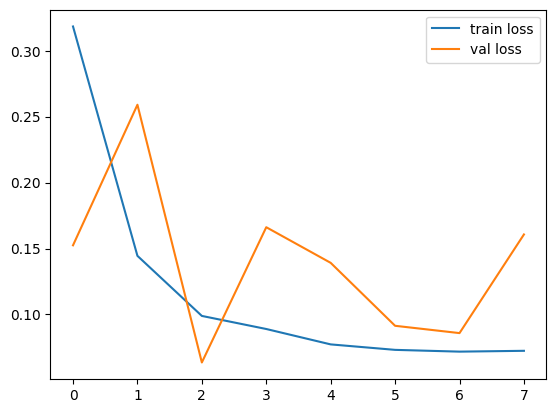

In [18]:
plt.plot(range(epochs), train_losses, val_losses)
plt.legend(['train loss', 'val loss'])

# Let's choose some random images from the validation set and see how our model performs.

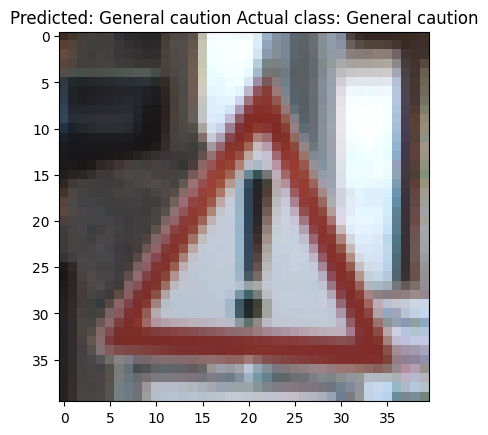

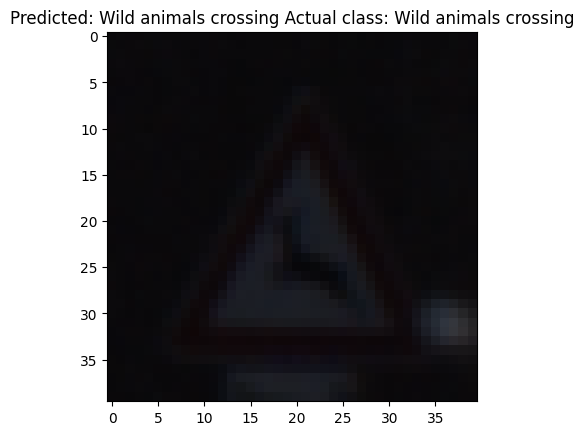

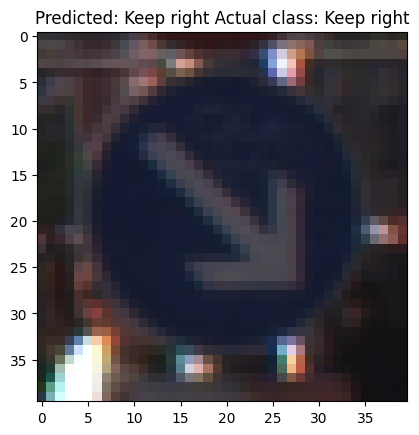

<Figure size 640x480 with 0 Axes>

In [19]:
net.eval()
X,y = next(iter(val_dataloader))

pred = net(X)
pred = torch.argmax(pred, dim=-1)

i = 0
for image,prediction, label in zip(X,pred, y):
  plt.title(f"Predicted: {classes[prediction]} Actual class: {classes[label]}")
  plt.imshow(  image.permute(1, 2, 0)  )
  plt.figure(i+1)
  i += 1

plt.show()

#That's it!

You can go further by trying different datasets (e.g CIFAR-10, ImageNet), different architectures (e.g VGG, ResNets), and different hyperparameters, image augmentation methods, and by seeing different Kaggle Image competitions and reading different solution.  